In [1]:
import torch
import torch.nn as nn
import numpy as np
import gym
import tushare as ts
import matplotlib.pyplot as plt

In [2]:
from IPython import display
display.set_matplotlib_formats("svg") ## 设置一下，这样一来，图片就是svg格式的矢量图了。

/var/folders/s1/1jpfx0m52rj4k7cgqkh7g3q40000gn/T/ipykernel_23962/2047429104.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg") ## 设置一下，这样一来，图片就是svg格式的矢量图了。


In [3]:
# 设置TuShare的token，需要提前在TuShare官网注册并获取token
token = "53b6254438e6d307b6799dbd575883528bc1da912f3d6a31159ecc9e"
ts.set_token(token)

In [4]:
# 初始化TuShare接口
pro = ts.pro_api()

In [5]:
# 数据收集
def collect_data():
    # 使用Tushare Pro版获取股票数据
    df = pro.daily(ts_code="000977.SZ", start_date="2010-01-01", end_date="2020-01-01")
    prices = df["close"].values.astype(float)
    return prices

In [6]:
prices = collect_data()

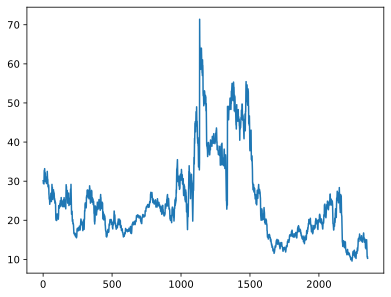

In [7]:
plt.plot(prices)

In [8]:
# 定义交易环境
class TradingEnvironment(gym.Env):
    '''总体给我的感觉，就是，一个管理强化学习状态的数据结构。
    比如当前的股价是多少，当前还有多少余钱，目前持股是多少。
    然后假设来了一个动作：买入、卖出、持有三者之一。
    之后，会有多少收益，然后能够达到的一个新的状态是怎么样的。
    最精华的部分应该是采取什么样的动作。这个东西需要后续的决策模块来做。
    '''
    def __init__(self, prices):
        super(TradingEnvironment, self).__init__()
        self.prices = prices ## 【TODO】这个后续可以看一下，数据形状是如何的。
        self.current_step = 0 ## 当前步数。如果步数到达某一上限，学习过程就终止了。
        self.balance = 10000  # 初始资金
        self.stock_inventory = 0 ## 这个应该是持股的数量。
        self.max_steps = len(prices) ## 这个就是步数的上限，看来就是股价的个数。相当于就是把所有的股价都刷一遍，看最终能收益多少。
        self.action_space = gym.spaces.Discrete(3)  # 三个动作：买入、卖出、持有
        self.observation_space = gym.spaces.Box( ## 这个未知，不知道是啥东西。后续我们跑跑代码再看。
            low=0, high=np.inf, shape=(2,), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.stock_inventory = 0
        return np.array([self.balance, self.stock_inventory]) ## 这个应该是状态，就是某时刻，有多少现金，有多少持股。

    def step(self, action):
        current_price = self.prices[self.current_step]
        if action == 0:  # 买入
            if self.balance >= current_price:
                num_to_buy = int(self.balance / current_price)
                self.balance -= num_to_buy * current_price
                self.stock_inventory += num_to_buy
        elif action == 1:  # 卖出
            if self.stock_inventory > 0:
                self.balance += self.stock_inventory * current_price
                self.stock_inventory = 0
        self.current_step += 1 ## 
        done = self.current_step >= self.max_steps
        reward = self.balance + self.stock_inventory * current_price - 10000  # 计算奖励 ## 看上去就是，把当前的余额和股票换算成钱，看跟最开始比挣了多少钱。 
        ## 每一步，返回一个，当前的余额、持股、收益、是否完结。最后一个空的dict不知道是什么意思。
        return np.array([self.balance, self.stock_inventory]), reward, done, {}

In [9]:
# 定义一个简单的深度神经网络策略，并添加L2正则化
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, l2_reg=0.01):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

        # 添加L2正则化到模型的所有线性层
        self.l2_reg = l2_reg
        self.l2_loss = nn.MSELoss(reduction='sum')

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def calculate_l2_regularization(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += self.l2_loss(param, target=torch.zeros_like(param))
        return l2_loss * self.l2_reg  # 缩放L2正则化项的权重

In [10]:
# 训练策略网络
def train_policy_network(prices, l2_reg=0.01):  # 添加L2正则化的参数
    env = TradingEnvironment(prices)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    policy_network = PolicyNetwork(input_dim, output_dim, l2_reg)  # 传递L2正则化参数
    optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.001)

    num_episodes = 10000
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        while True:
            state_tensor = torch.FloatTensor(state)
            action_logits = policy_network(state_tensor)
            action_prob = torch.softmax(action_logits, dim=-1)
            action = np.random.choice(output_dim, p=action_prob.detach().numpy())

            next_state, reward, done, _ = env.step(action)

            if done:
                break

            episode_reward += reward
            state = next_state

        # 计算L2正则化项并添加到损失中
        l2_loss = policy_network.calculate_l2_regularization()
        loss = -torch.tensor([episode_reward], dtype=torch.float32, requires_grad=True) + l2_loss ## 这个的损失非常有意思，是网络的结构的损失以及收益的负数。
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")
            rewards.append(episode_reward)

    return policy_network, rewards

Episode 10/10000, Reward: -4093978.32
Episode 20/10000, Reward: -3877834.11
Episode 30/10000, Reward: -3982733.83
Episode 40/10000, Reward: -4198925.40
Episode 50/10000, Reward: -8947683.57
Episode 60/10000, Reward: 0.00
Episode 70/10000, Reward: 0.00
Episode 80/10000, Reward: 0.00
Episode 90/10000, Reward: -4028924.07
Episode 100/10000, Reward: 2406483.44
Episode 110/10000, Reward: 1444048.27
Episode 120/10000, Reward: -7219517.69
Episode 130/10000, Reward: -4520547.46
Episode 140/10000, Reward: 11166544.40
Episode 150/10000, Reward: -10429020.07
Episode 160/10000, Reward: 3013748.24
Episode 170/10000, Reward: 11086063.50
Episode 180/10000, Reward: -11706054.31
Episode 190/10000, Reward: -5913392.21
Episode 200/10000, Reward: -3122130.66
Episode 210/10000, Reward: 1690717.15
Episode 220/10000, Reward: -3715549.77
Episode 230/10000, Reward: -8511247.19
Episode 240/10000, Reward: 10207235.20
Episode 250/10000, Reward: -5253111.38
Episode 260/10000, Reward: 4410363.87
Episode 270/10000, 

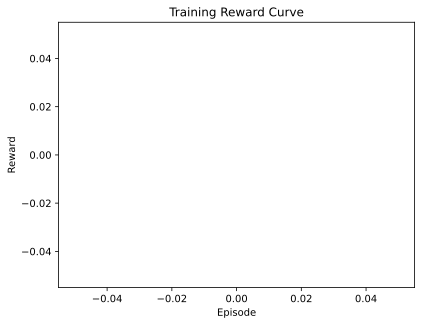

In [11]:
# 主函数
if __name__ == "__main__":
    # 收集数据
    # prices = collect_data()

    # 训练策略网络，传递L2正则化参数
    policy_network, rewards = train_policy_network(prices + 1e-3, l2_reg=0.01)

    # 保存模型
    torch.save(policy_network.state_dict(), "policy_network.pth")

    # 绘制奖励曲线
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Reward Curve")
    plt.show()